## Environment setup

In [ ]:
!pip install optbinning seaborn statsmodels feature-engine --quiet
!pip install openmeteo-requests --quiet
!pip install requests-cache retry-requests numpy pandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.8/669.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.9/247.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.4/393.4 kB 14.6 MB/s eta 0:00:00
   ━━

In [ ]:
!pip install Boruta --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from functools import reduce


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer, QuantileTransformer
from optbinning import OptimalBinning

from boruta import BorutaPy

In [ ]:
from statsmodels.datasets import grunfeld
from sklearn.datasets import fetch_openml

## Functions, utils and helpers

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2, R=6371):
    """
    Calculates the Haversine distance between two sets of geographic coordinates
    using NumPy for vectorized operations.

    Args:
        lat1 (np.array or scalar): Latitude(s) of the first point(s) in degrees.
        lon1 (np.array or scalar): Longitude(s) of the first point(s) in degrees.
        lat2 (np.array or scalar): Latitude(s) of the second point(s) in degrees.
        lon2 (np.array or scalar): Longitude(s) of the second point(s) in degrees.
        R (float): Radius of the Earth in kilometers (default is 6371 km).

    Returns:
        np.array or scalar: The Haversine distance(s) in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in latitude and longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance


# Loading weather data

In [ ]:
import openmeteo_requests

import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.715422,
	"longitude": 74.01122,
	"start_date": "2015-01-01",
	"end_date": "2019-12-31",
	"hourly": ["temperature_2m", "snowfall", "precipitation", "apparent_temperature"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["snowfall"] = hourly_snowfall
hourly_data["precipitation"] = hourly_precipitation
hourly_data["apparent_temperature"] = hourly_apparent_temperature

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 40.738136291503906°N 74.17021179199219°E
Elevation 3852.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s
                           date  temperature_2m  snowfall  precipitation  \
0     2015-01-01 04:00:00+00:00      -22.845501       0.0            0.0   
1     2015-01-01 05:00:00+00:00      -20.745501       0.0            0.0   
2     2015-01-01 06:00:00+00:00      -17.345501       0.0            0.0   
3     2015-01-01 07:00:00+00:00      -16.895500       0.0            0.0   
4     2015-01-01 08:00:00+00:00      -15.395500       0.0            0.0   
...                         ...             ...       ...            ...   
43819 2019-12-31 23:00:00+00:00      -24.819500       0.0            0.0   
43820 2020-01-01 00:00:00+00:00      -23.669500       0.0            0.0   
43821 2020-01-01 01:00:00+00:00      -25.919500       0.0            0.0   
43822 2020-01-01 02:00:00+00:00      -26.369499       0.0            0.0   
43823 2020-01

In [ ]:
hourly_dataframe

,date,temperature_2m,snowfall,precipitation,apparent_temperature
0,2015-01-01 04:00:00+00:00,-22.845501,0.0,0.0,-27.445871
1,2015-01-01 05:00:00+00:00,-20.745501,0.0,0.0,-25.273024
2,2015-01-01 06:00:00+00:00,-17.345501,0.0,0.0,-22.025776
3,2015-01-01 07:00:00+00:00,-16.895500,0.0,0.0,-21.540409
4,2015-01-01 08:00:00+00:00,-15.395500,0.0,0.0,-20.034956
...,...,...,...,...,...
43819,2019-12-31 23:00:00+00:00,-24.819500,0.0,0.0,-29.475616
43820,2020-01-01 00:00:00+00:00,-23.669500,0.0,0.0,-28.621515
43821,2020-01-01 01:00:00+00:00,-25.919500,0.0,0.0,-30.801432
43822,2020-01-01 02:00:00+00:00,-26.369499,0.0,0.0,-31.256304


# Loading the data

In [ ]:
data = fetch_openml(data_id=43526, as_frame=True)

In [ ]:
print(data['DESCR'])
display(pd.DataFrame(data['details'].items()))

The New York City Bike Share enables quick, easy, and affordable bike trips around the New York city boroughs. They make regular open data releases (this dataset is a transformed version of the data from this link). The dataset contains 735502 anonymised trips information made from Jan 2015 to June 2017.
Acknowledgements -
This dataset is the property of NYC Bike Share, LLC and Jersey City Bike Share, LLC (Bikeshare) operates New York Citys Citi Bike bicycle sharing service for TC click here
Objectives -

EDA
Feature Engineering
Predict Gender of the riders

Downloaded from openml.org.


,0,1
0,id,43526
1,name,New-York-City-Bike-Share-Dataset
2,version,1
3,description_version,1
4,format,arff
5,collection_date,25-07-2017
6,upload_date,2022-03-23T13:36:53
7,language,English
8,licence,CC BY-NC-SA 4.0
9,url,https://api.openml.org/data/v1/download/221023...


In [ ]:
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
df_bike = (
    data.frame
    .copy()
    [[
        'Bike_ID',
        'User_Type',
        'Birth_Year',
        'Gender',
        'Start_Time',
        'Stop_Time',
        'Trip_Duration',
        'Trip_Duration_in_min',
        'Start_Station_ID',
        'Start_Station_Name',
        'Start_Station_Latitude',
        'Start_Station_Longitude',
        'End_Station_ID',
        'End_Station_Name',
        'End_Station_Latitude',
        'End_Station_Longitude',
    ]]
    .rename(columns=lambda x:x.lower())
    .assign(
        start_time=lambda x:pd.to_datetime(x['start_time']),
        stop_time=lambda x:pd.to_datetime(x['stop_time']),
    )
    .query('end_station_id !=3442')
    .assign(
        week_id = lambda x: x['start_time'].dt.to_period('W').dt.to_timestamp(how='start'),
        date_ref = lambda x: x['start_time'].dt.to_period('D').dt.to_timestamp(how='start'),
    )
)

In [ ]:
df_bike.head()

,bike_id,user_type,birth_year,gender,start_time,stop_time,trip_duration,trip_duration_in_min,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,week_id,date_ref
0,24470,Subscriber,1960.0,1,2015-10-01 00:16:26,2015-10-01 00:22:42,376,6,3212,'Christ Hospital',40.734786,-74.050444,3207,'Oakland Ave',40.737604,-74.052478,2015-09-28,2015-10-01
1,24481,Subscriber,1960.0,1,2015-10-01 00:27:12,2015-10-01 00:39:32,739,12,3207,'Oakland Ave',40.737604,-74.052478,3212,'Christ Hospital',40.734786,-74.050444,2015-09-28,2015-10-01
2,24628,Subscriber,1983.0,1,2015-10-01 00:32:46,2015-10-01 01:18:01,2714,45,3193,'Lincoln Park',40.724605,-74.078406,3193,'Lincoln Park',40.724605,-74.078406,2015-09-28,2015-10-01
3,24613,Subscriber,1975.0,1,2015-10-01 00:34:31,2015-10-01 00:39:06,275,5,3199,'Newport Pkwy',40.728745,-74.032108,3187,'Warren St',40.721124,-74.038051,2015-09-28,2015-10-01
4,24668,Customer,1984.0,0,2015-10-01 00:40:12,2015-10-01 00:49:33,561,9,3183,'Exchange Place',40.716247,-74.033459,3192,'Liberty Light Rail',40.711242,-74.055701,2015-09-28,2015-10-01


# Feature engineering

## distance between stations

In [ ]:
start_station = (
    df_bike[['start_station_id','start_station_name', 'start_station_latitude','start_station_longitude']]
    .drop_duplicates()
    .rename(columns=lambda x:x.replace('start_station_',''))
)

end_station = (
    df_bike[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
    .drop_duplicates()
    .rename(columns=lambda x:x.replace('end_station_','').lower())
)

stations = pd.concat([start_station, end_station]).drop_duplicates().sort_values('id')

In [ ]:
stations

,id,name,latitude,longitude
113366,147,'Greenwich St Warren St',40.715422,-74.011220
355303,152,'Warren St Church St',40.714740,-74.009106
121625,173,'Broadway W 49 St',40.760683,-73.984527
322701,224,'Spruce St Nassau St',40.711464,-74.005524
96569,225,'W 14 St The High Line',40.741951,-74.008030
...,...,...,...,...
293384,3280,'Astor Place',40.719282,-74.071262
196845,3281,'Leonard Gordon Park',40.745910,-74.057271
204390,3314,'W 95 St Broadway',40.793770,-73.971888
220888,3331,'Riverside Dr W 104 St',40.801343,-73.971146


In [ ]:
def cal_geotile(df, zoom=10000):
    lat = df['latitude']
    lat_rad = np.radians(lat)
    lon = df['longitude']
    n = 2 ^ zoom
    xtile = n * ((lon + 180) / 360)
    ytile = n * (1 - (np.log(np.tan(lat_rad) + 1/np.cos(lat_rad)) / np.pi)) / 2
    df['tile'] = xtile.astype(int).astype(str) + '-' + ytile.astype(int).astype(str)
    return df

In [ ]:
stations.pipe(cal_geotile).groupby('tile').size()

,0
tile,
2942-3760,6
2942-3761,3
2943-3759,12
2943-3760,25
2944-3758,1
2944-3759,8
2944-3760,27
2945-3757,4
2945-3758,8


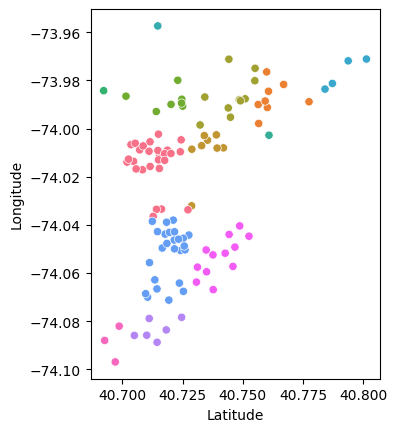

In [ ]:
sns.scatterplot(data=stations.query('longitude != 0'),y='longitude', x='latitude', hue='tile')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend().set_visible(False)

In [ ]:
# prompt: calculate the distance matrix for all pairs of stations in stations using geodistance
def create_distance_matrix(points_id, latitudes, longitudes):
    # Calculate distance matrix using vectorized haversine_distance
    num_stations = len(stations)
    distance_matrix = np.zeros((num_stations, num_stations))

    # Expand dimensions for broadcasting
    lat1_expanded = latitudes[:, np.newaxis]
    lon1_expanded = longitudes[:, np.newaxis]
    lat2_expanded = latitudes[np.newaxis, :]
    lon2_expanded = longitudes[np.newaxis, :]

    distance_matrix = haversine_distance(lat1_expanded, lon1_expanded, lat2_expanded, lon2_expanded)

    # Convert to DataFrame for better readability and indexing
    distance_matrix_df = pd.DataFrame(distance_matrix, index=points_id, columns=points_id)
    return distance_matrix_df

distance_matrix_df= create_distance_matrix(stations['id'], stations['latitude'].values, stations['longitude'].values)

In [ ]:
distance_matrix_df = (
    distance_matrix_df.reset_index().melt(
        id_vars='id',
        var_name='dest',
        value_name='distance'
    )
    .rename(columns={
        'id':'start_station_id',
        'dest':'end_station_id'
    })
)

In [ ]:
df_bike_v2 = (
    df_bike
    .merge(distance_matrix_df, on=['start_station_id','end_station_id'], how='left')
    .drop(columns=['start_station_longitude','start_station_latitude','start_station_name'])
    .drop(columns=['end_station_longitude','end_station_latitude','end_station_name'])
)

array([[<Axes: title={'center': 'n'}>]], dtype=object)

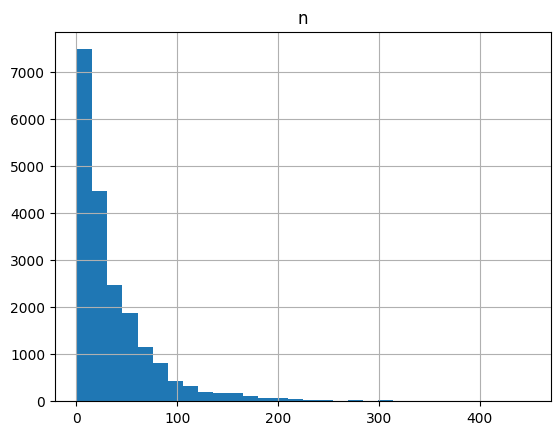

In [ ]:
df_bike_v2.groupby(['start_station_id','date_ref']).size().to_frame('n').hist(bins=30)

In [ ]:
df_bike_v2['user_type'].value_counts()

,count
user_type,
Subscriber,688140
Customer,47358


# Spine creation

In [ ]:
class FPercentile:
    def __init__(self, percentile):
        self.percentile = percentile

    def __call__(self, s):
        return np.percentile(s, 99)

    def __str__(self):
        return f"p{self.percentile}"

fp99 = FPercentile(99)
fp05 = FPercentile(5)

In [ ]:
# prompt: add date time features like  hour,  dayofweek, so on so fourth  to df_bike_v2  for the column start_time


feature_engineering_dict = {
    'trip_duration_in_min':['mean','min','sum'],
    'distance':['mean','min',fp05,fp99],
    'age':['mean','median',fp05,fp99],
    'gender':['mean'],
    'isSubscripber':['mean'],
    'age_00_24':['mean'],
    'age_25_34':['mean'],
    'age_35_44':['mean'],
    'age_45_00'     :['mean'],
    'temperature_2m':['mean'],
    'snowfall':['sum'],
    'precipitation':['sum','mean'],
    'apparent_temperature':['max','median','mean'],
}

df_bike_v3 = (
    df_bike_v2
    .eval('gender = gender==1')
    .eval('isSubscripber = user_type=="Subscriber"')
    .eval('age = date_ref.dt.year - birth_year')
    .eval('age_00_24 = age <= 24')
    .eval('age_25_34 = age > 24 and age <= 34')
    .eval('age_35_44 = age > 34 and age <= 44')
    .eval('age_45_00 = age > 44')

    .merge(
        hourly_dataframe
        .rename(columns={'date':'date_ref'})
        .assign(date_ref = lambda x:x['date_ref'].dt.tz_convert(None)),
        how='left'
    )

    .groupby(['start_station_id','date_ref'])
    .agg(
    **{'n_rents':('bike_id','size'),},
    **{
        f'{v}_{func}':(v,func)
            for v in feature_engineering_dict.keys()
            for func in feature_engineering_dict[v]
    })
    .reset_index()
    .eval('weekday = date_ref.dt.weekday')
    .eval('month = date_ref.dt.month')
    # .eval('hour = date_ref.dt.hour
)

df_all_combinations = pd.DataFrame([[k, d]
    for k in df_bike_v3['start_station_id'].unique()
    for d in pd.date_range(df_bike_v3['date_ref'].min(), df_bike_v3['date_ref'].max(), freq='D')
], columns=['start_station_id', 'date_ref'])

df_bike_v3 = df_all_combinations.merge(df_bike_v3, on=['start_station_id', 'date_ref'], how='left').fillna(0)

In [ ]:
df_bike_v3

,start_station_id,date_ref,n_rents,trip_duration_in_min_mean,trip_duration_in_min_min,trip_duration_in_min_sum,distance_mean,distance_min,distance_p5,distance_p99,...,age_45_00_mean,temperature_2m_mean,snowfall_sum,precipitation_sum,precipitation_mean,apparent_temperature_max,apparent_temperature_median,apparent_temperature_mean,weekday,month
0,3183,2015-09-21,29.0,12.034483,2.0,349.0,1.045365,0.0,3.563407,3.563407,...,0.206897,-8.8955,0.0,0.0,0.0,-13.181628,-13.181628,-13.181628,0.0,9.0
1,3183,2015-09-22,64.0,9.843750,2.0,630.0,1.287667,0.0,3.984896,3.984896,...,0.140625,-8.7955,0.0,0.0,0.0,-12.778499,-12.778499,-12.778499,1.0,9.0
2,3183,2015-09-23,60.0,12.850000,2.0,771.0,1.095387,0.0,3.820818,3.820818,...,0.233333,-7.4955,0.0,0.0,0.0,-11.131539,-11.131539,-11.131539,2.0,9.0
3,3183,2015-09-24,51.0,9.196078,2.0,469.0,1.008318,0.0,3.320056,3.320056,...,0.196078,-8.1955,0.0,0.0,0.0,-12.060068,-12.060068,-12.060068,3.0,9.0
4,3183,2015-09-25,46.0,11.652174,2.0,536.0,1.111958,0.0,3.320056,3.320056,...,0.195652,-7.0455,0.0,0.0,0.0,-10.684884,-10.684884,-10.684884,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,3426,2017-03-27,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
28454,3426,2017-03-28,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
28455,3426,2017-03-29,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
28456,3426,2017-03-30,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


<Axes: title={'center': 'load per weekday'}, xlabel='date_ref'>

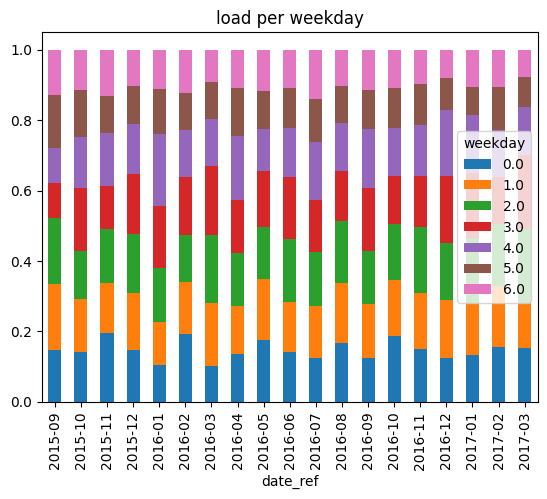

In [ ]:
(
    df_bike_v3
    .eval('date_ref = date_ref.dt.to_period("M")', engine='python')
    .pivot_table(index='date_ref', columns='weekday' , values='n_rents', aggfunc='sum')
    .pipe(lambda df:df.div(df.sum(axis=1), axis=0))
    .plot(kind='bar', stacked=True, title="load per weekday")
)

In [ ]:
df_bike_v3.columns

Index(['start_station_id', 'date_ref', 'n_rents', 'trip_duration_in_min_mean',
       'trip_duration_in_min_min', 'trip_duration_in_min_sum', 'distance_mean',
       'distance_min', 'distance_p5', 'distance_p99', 'age_mean', 'age_median',
       'age_p5', 'age_p99', 'gender_mean', 'isSubscripber_mean',
       'age_00_24_mean', 'age_25_34_mean', 'age_35_44_mean', 'age_45_00_mean',
       'temperature_2m_mean', 'snowfall_sum', 'precipitation_sum',
       'precipitation_mean', 'apparent_temperature_max',
       'apparent_temperature_median', 'apparent_temperature_mean', 'weekday',
       'month'],
      dtype='object')

In [ ]:
def window_features(df):
    for v in ['n_rents','isSubscripber_mean','age_00_24_mean', 'age_25_34_mean','snowfall_sum','isSubscripber_mean','trip_duration_in_min_mean','precipitation_mean',]:
        for l in [1, 7, 15, 30, 60]:
            df[f'{v}_lag_{l}'] = df[v].shift(l)
            df[f'{v}_var_{l}'] = df[v]/df[v].shift(l)
            df[f'{v}_rollmean_{l}'] = df[v].rolling(l).mean()
            df[f'{v}_rollsum_{l}'] = df[v].rolling(l).mean()

    df = df.replace([np.inf,-np.inf],0)

    ################# The target
    # df = df.assign(target = lambda x:x['n_rents'].shift(-6).rolling(window=3, min_periods=1).sum())
    df = df.assign(target_bruto = lambda x:(x['n_rents'].shift(-1)+1)/(x['n_rents']+1))
    df = df.assign(target = lambda x:x['target_bruto']>1.3)

    df = df.dropna()

    return df;


df_bike_v4 = (
    df_bike_v3
    .reset_index(drop=True)
    .copy()
    .groupby('start_station_id')
    .apply(window_features)
    .eval('is_train = (date_ref < "2016-03-01")*1')
    .eval('is_test = ((is_train == 0 ) & (date_ref < "2016-06-01"))*1')
    .eval('is_validation = (is_train ==0) & (is_test == 0 )')
    .dropna()
    .reset_index(drop=True)
)

df_bike_v4

In [ ]:
#df_bike_v4.query('is_train==1')['target'].describe(percentiles=np.linspace(0,1,11))

## Feature validations - Missing values

In [ ]:
df_missings = reduce(
    lambda x,y: pd.merge(x,y, left_index=True, right_index=True, how='outer'),
    [
        df_bike_v4.isna().mean().to_frame('nmiss'),
        df_bike_v4.apply(np.isinf).mean().to_frame('ninf'),
    ]
)

In [ ]:
df_missings.eval('invalid = nmiss + ninf').query('invalid > 0')

,nmiss,ninf,invalid


# Training the model

In [ ]:
from sklearn.feature_selection import SelectFromModel, RFECV, RFE, SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import shap

In [ ]:
# Time-based split
df_bike_v4 = df_bike_v4.astype({'weekday':'category','month':'category'})
df_bike_v4['random_flag'] = np.random.RandomState(42).rand(len(df_bike_v4))
train = df_bike_v4.query('is_train == 1').copy()
cols_to_remove = ['start_station_id', 'date_ref', 'is_train', 'is_test', 'is_validation', 'target_bruto','bucket','prediction']
train = train.drop(columns=[c for c in cols_to_remove if c in train.columns])

/tmp/ipython-input-378-669094137.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bike_v4['random_flag'] = np.random.RandomState(42).rand(len(df_bike_v4))


In [ ]:
y_target = 'target'

In [ ]:
(
    train
    .corr()[[y_target]]
    .abs()
    .query('target < 1 and target>0.1')
    .sort_values('target', ascending=False)
)

,target
precipitation_mean_var_1,0.316226
n_rents_rollmean_1,0.308959
n_rents,0.308959
n_rents_rollsum_1,0.308959
n_rents_var_1,0.294004
weekday,0.285325
precipitation_mean,0.268648
precipitation_mean_rollsum_1,0.268648
precipitation_mean_rollmean_1,0.268648
snowfall_sum_lag_30,0.263537


<Axes: xlabel='groups'>

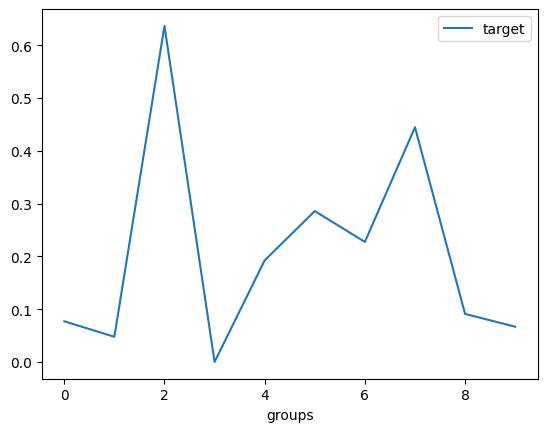

In [ ]:
(
    train
    .eval('groups = floor(apparent_temperature_max.rank(pct=True)*10)')
    .groupby('groups')
    .agg(
        n=('n_rents','count'),
        target=('target','mean'),
    )
    .eval('pct = n /n.sum()')
    .plot(y='target')
)

In [ ]:
def combined_calibration_auc_score(y_true, y_prob, n_bins=10):
    """
    Compute a custom score that combines calibration (R² of calibration curve) and AUC.

    Parameters:
        y_true: array-like of shape (n_samples,)
        y_prob: array-like of shape (n_samples,) — predicted probabilities for the positive class
        n_bins: int — number of bins used in calibration curve


    Returns:
        combined_score: float — weighted sum of R² times AUC

    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    r2_calibration = r2_score(prob_true, prob_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    combined = r2_calibration * auc_score

    return combined

# Wrap as a scorer
combined_scorer = make_scorer(
    combined_calibration_auc_score,
    response_method='predict_proba',
    greater_is_better=True
)

In [ ]:
def run_simulation(df, target_col, estimator, features, cv=10):
    metrics = []
    for i in range(cv):
        df_sample = df.sample(frac=0.8, random_state=42);
        estimator.fit(df_sample[features], df_sample[target_col]);
        prob = estimator.predict_proba(df[features])[:,1]
        metric = combined_calibration_auc_score(df[y_target], prob)
        metrics.append(metric)
    return np.array(metric).mean()

In [ ]:
possible_features = train.drop(columns=[y_target]+[c for c in cols_to_remove if c in train.columns]).columns

In [ ]:
# base_dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01)
base_dt = HistGradientBoostingClassifier(learning_rate=0.01)
metrics = [run_simulation(train, y_target, base_dt, [f]) for f in tqdm(possible_features)]

In [453]:
df_possible_features = pd.DataFrame({'possible_features':possible_features, 'metrics':metrics})

In [454]:
df_correl = (
    train[df_possible_features['possible_features']]
    .corr()
    .abs()
    # .reset_index()
    # .melt(
    #     id_vars='index',
    #     var_name='v2',
    #     value_name='correl'
    # )
    # .rename(columns={'index':'possible_features'})
)
df_correl

,n_rents,trip_duration_in_min_mean,trip_duration_in_min_min,trip_duration_in_min_sum,distance_mean,distance_min,distance_p5,distance_p99,age_mean,age_median,...,precipitation_mean_rollsum_15,precipitation_mean_lag_30,precipitation_mean_var_30,precipitation_mean_rollmean_30,precipitation_mean_rollsum_30,precipitation_mean_lag_60,precipitation_mean_var_60,precipitation_mean_rollmean_60,precipitation_mean_rollsum_60,random_flag
n_rents,1.000000,0.094371,0.469089,0.383984,0.350563,0.413237,0.115921,0.115921,0.219282,0.169789,...,0.075002,0.074113,0.000581,0.131496,0.131496,0.084177,0.095784,0.029994,0.029994,0.062455
trip_duration_in_min_mean,0.094371,1.000000,0.029346,0.819325,0.044848,0.071053,0.041189,0.041189,0.057488,0.052424,...,0.048370,0.155015,0.077346,0.071698,0.071698,0.014956,0.007686,0.067541,0.067541,0.047611
trip_duration_in_min_min,0.469089,0.029346,1.000000,0.197499,0.699333,0.593629,0.212700,0.212700,0.222783,0.084256,...,0.104232,0.068406,0.009651,0.094437,0.094437,0.018582,0.034062,0.038981,0.038981,0.067670
trip_duration_in_min_sum,0.383984,0.819325,0.197499,1.000000,0.115801,0.258657,0.026571,0.026571,0.069345,0.048840,...,0.092467,0.127806,0.085394,0.131513,0.131513,0.078306,0.076896,0.092046,0.092046,0.032051
distance_mean,0.350563,0.044848,0.699333,0.115801,1.000000,0.637357,0.606147,0.606147,0.018528,0.111174,...,0.226218,0.098623,0.002182,0.231468,0.231468,0.047867,0.028865,0.147501,0.147501,0.072223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
precipitation_mean_lag_60,0.084177,0.014956,0.018582,0.078306,0.047867,0.055562,0.104342,0.104342,0.035776,0.096347,...,0.315332,0.049604,0.058607,0.185267,0.185267,1.000000,0.132638,0.084007,0.084007,0.097853
precipitation_mean_var_60,0.095784,0.007686,0.034062,0.076896,0.028865,0.027184,0.092483,0.092483,0.073954,0.063410,...,0.157191,0.504169,0.492962,0.105968,0.105968,0.132638,1.000000,0.024117,0.024117,0.022419
precipitation_mean_rollmean_60,0.029994,0.067541,0.038981,0.092046,0.147501,0.050716,0.086688,0.086688,0.020092,0.036675,...,0.704686,0.110121,0.221878,0.832812,0.832812,0.084007,0.024117,1.000000,1.000000,0.047357
precipitation_mean_rollsum_60,0.029994,0.067541,0.038981,0.092046,0.147501,0.050716,0.086688,0.086688,0.020092,0.036675,...,0.704686,0.110121,0.221878,0.832812,0.832812,0.084007,0.024117,1.000000,1.000000,0.047357


In [455]:
df_correl = df_correl * (1-np.eye(df_correl.shape[0], df_correl.shape[1]))

In [456]:
df_correl.loc[['weekday','age_00_24_mean_lag_15'],'weekday'].max()

0.0884752425233662

In [459]:
filtered_features = []
metrics_dict = dict(zip(possible_features, metrics))

for f in possible_features:
    if len(filtered_features) > 0:
        if df_correl.loc[filtered_features, f].max() < 0.5:
            filtered_features.append(f)
    else:
        filtered_features.append(f)

In [460]:
filtered_features

['n_rents',
 'trip_duration_in_min_mean',
 'trip_duration_in_min_min',
 'distance_p5',
 'age_mean',
 'gender_mean',
 'isSubscripber_mean',
 'age_35_44_mean',
 'temperature_2m_mean',
 'weekday',
 'month',
 'n_rents_var_1',
 'n_rents_var_7',
 'n_rents_var_15',
 'n_rents_var_30',
 'n_rents_lag_60',
 'n_rents_var_60',
 'isSubscripber_mean_lag_1',
 'isSubscripber_mean_lag_7',
 'isSubscripber_mean_var_7',
 'isSubscripber_mean_lag_15',
 'isSubscripber_mean_var_15',
 'isSubscripber_mean_lag_30',
 'isSubscripber_mean_lag_60',
 'isSubscripber_mean_var_60',
 'isSubscripber_mean_rollmean_60',
 'age_00_24_mean_lag_1',
 'age_00_24_mean_var_1',
 'age_00_24_mean_lag_7',
 'age_00_24_mean_var_7',
 'age_00_24_mean_lag_15',
 'age_00_24_mean_var_15',
 'age_00_24_mean_lag_30',
 'age_00_24_mean_var_30',
 'age_00_24_mean_lag_60',
 'age_00_24_mean_var_60',
 'age_00_24_mean_rollmean_60',
 'age_25_34_mean_lag_1',
 'age_25_34_mean_var_1',
 'age_25_34_mean_var_7',
 'age_25_34_mean_var_15',
 'age_25_34_mean_lag_30'

In [ ]:
possible_features = df_possible_features['possible_features'].values.tolist()

In [ ]:
from collections import defaultdict
selected_features = [possible_features.pop(0)]
current_score = run_simulation(train, y_target, base_dt, selected_features)
features_counter = defaultdict(int)
features_counter[selected_features[0]]+=1;

has_improvements = True;

hist = [current_score]

while has_improvements or len(possible_features) > 0:
    new_feature = possible_features.pop(0)
    if features_counter[new_feature] > 2:
        continue;

    features_counter[new_feature]+=1;

    selected_features.append(new_feature)
    new_score = run_simulation(train, y_target, base_dt, selected_features)
    has_improvements = (new_score / current_score) >1.01
    # has_improvements = True
    # print(f"iter: {new_feature:<20} - {current_score:0.2} - {new_score:0.2}  - {has_improvements} - {new_score / current_score}")
    if has_improvements:
        print(selected_features)
        print(f"{new_score / current_score}")
        current_score = new_score
        hist.append(current_score)
    else:
        possible_features.append(selected_features.pop())


['weekday', 'n_rents_var_15']
1.0504733446359371
['weekday', 'n_rents_var_15', 'age_00_24_mean']
1.0150080741081016
['weekday', 'n_rents_var_15', 'age_00_24_mean', 'age_00_24_mean_rollsum_15']
1.0153452815327622


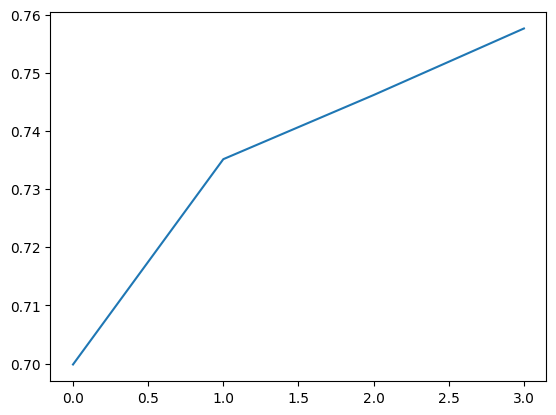

In [ ]:
plt.plot(np.array(hist))

In [ ]:
# pprint(df_possible_features['possible_features'].values.tolist())

In [ ]:
def plot_ts(df, title=''):
    (
        df
        .eval('date_ref = date_ref.dt.to_period("M")', engine='python')
        .pivot_table(index='date_ref',columns='bucket', values='target', aggfunc='mean')
        .plot(figsize=(15,5), marker='o', title=title)
    );

In [ ]:
# pprint(np.sort(train.columns.tolist()).tolist())

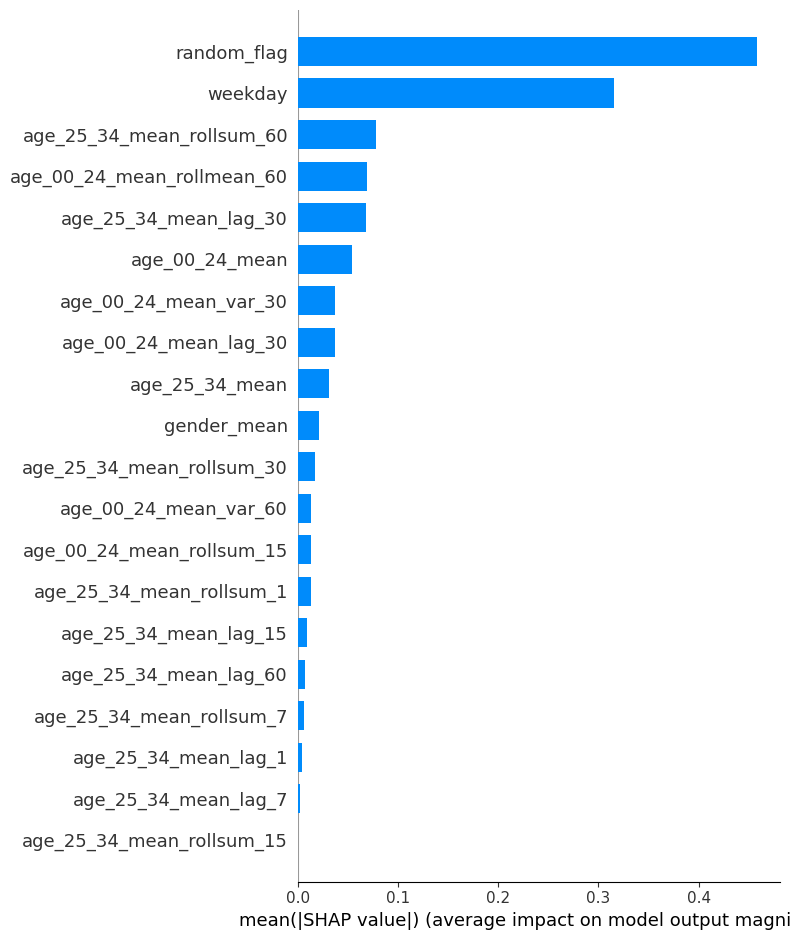

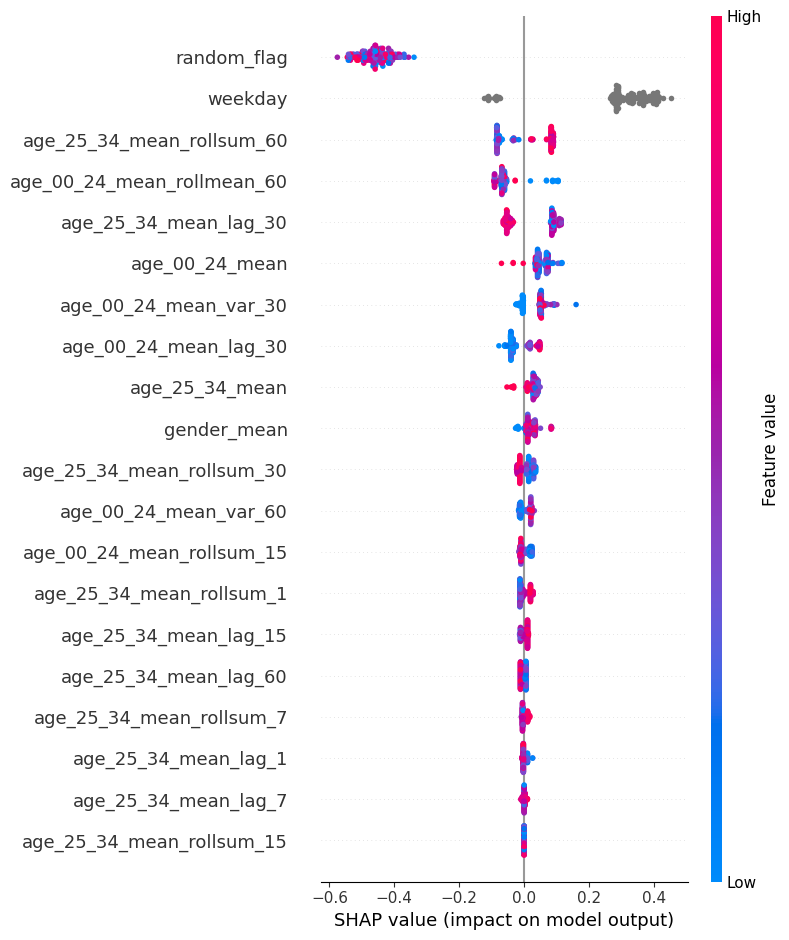

In [ ]:
X_features = [
    'random_flag',
    'age_00_24_mean',
 'age_00_24_mean_lag_30',
 'age_00_24_mean_rollmean_60',
 'age_00_24_mean_rollsum_15',
 'age_00_24_mean_var_30',
 'age_00_24_mean_var_60',
 'age_25_34_mean',
 'age_25_34_mean_lag_1',
 'age_25_34_mean_lag_15',
 'age_25_34_mean_lag_30',
 'age_25_34_mean_lag_60',
 'age_25_34_mean_lag_7',
 'age_25_34_mean_rollsum_1',
 'age_25_34_mean_rollsum_15',
 'age_25_34_mean_rollsum_30',
 'age_25_34_mean_rollsum_60',
 'age_25_34_mean_rollsum_7',
#  'age_25_34_mean_var_1',
#  'age_25_34_mean_var_15',
#  'age_25_34_mean_var_30',
#  'age_25_34_mean_var_60',
#  'age_25_34_mean_var_7',
#  'age_35_44_mean',
#  'age_45_00_mean',
#  'age_mean',
#  'age_median',
#  'age_p5',
#  'age_p99',
#  'apparent_temperature_max',
#  'apparent_temperature_mean',
#  'apparent_temperature_median',
#  'distance_mean',
#  'distance_min',
#  'distance_p5',
#  'distance_p99',
 'gender_mean',
#  'isSubscripber_mean',
#  'isSubscripber_mean_lag_1',
#  'isSubscripber_mean_lag_15',
#  'isSubscripber_mean_lag_30',
#  'isSubscripber_mean_lag_60',
#  'isSubscripber_mean_lag_7',
#  'isSubscripber_mean_rollmean_1',
#  'isSubscripber_mean_rollmean_15',
#  'isSubscripber_mean_rollmean_30',
#  'isSubscripber_mean_rollmean_60',
#  'isSubscripber_mean_rollmean_7',
#  'isSubscripber_mean_rollsum_1',
#  'isSubscripber_mean_rollsum_15',
#  'isSubscripber_mean_rollsum_30',
#  'isSubscripber_mean_rollsum_60',
#  'isSubscripber_mean_rollsum_7',
#  'isSubscripber_mean_var_1',
#  'isSubscripber_mean_var_15',
#  'isSubscripber_mean_var_30',
#  'isSubscripber_mean_var_60',
#  'isSubscripber_mean_var_7',
#  'month',
#  'n_rents',
#  'n_rents_lag_1',
#  'n_rents_lag_15',
#  'n_rents_lag_30',
#  'n_rents_lag_60',
#  'n_rents_lag_7',
#  'n_rents_rollmean_1',
#  'n_rents_rollmean_15',
#  'n_rents_rollmean_30',
#  'n_rents_rollmean_60',
#  'n_rents_rollmean_7',
#  'n_rents_rollsum_1',
#  'n_rents_rollsum_15',
#  'n_rents_rollsum_30',
#  'n_rents_rollsum_60',
#  'n_rents_rollsum_7',
#  'n_rents_var_1',
#  'n_rents_var_15',
#  'n_rents_var_30',
#  'n_rents_var_60',
#  'n_rents_var_7',
#  'precipitation_mean',
#  'precipitation_mean_lag_1',
#  'precipitation_mean_lag_15',
#  'precipitation_mean_lag_30',
#  'precipitation_mean_lag_60',
#  'precipitation_mean_lag_7',
#  'precipitation_mean_rollmean_1',
#  'precipitation_mean_rollmean_15',
#  'precipitation_mean_rollmean_30',
#  'precipitation_mean_rollmean_60',
#  'precipitation_mean_rollmean_7',
#  'precipitation_mean_rollsum_1',
#  'precipitation_mean_rollsum_15',
#  'precipitation_mean_rollsum_30',
#  'precipitation_mean_rollsum_60',
#  'precipitation_mean_rollsum_7',
#  'precipitation_mean_var_1',
#  'precipitation_mean_var_15',
#  'precipitation_mean_var_30',
#  'precipitation_mean_var_60',
#  'precipitation_mean_var_7',
#  'precipitation_sum',
#  'prediction',
#  'snowfall_sum',
#  'snowfall_sum_lag_1',
#  'snowfall_sum_lag_15',
#  'snowfall_sum_lag_30',
#  'snowfall_sum_lag_60',
#  'snowfall_sum_lag_7',
#  'snowfall_sum_rollmean_1',
#  'snowfall_sum_rollmean_15',
#  'snowfall_sum_rollmean_30',
#  'snowfall_sum_rollmean_60',
#  'snowfall_sum_rollmean_7',
#  'snowfall_sum_rollsum_1',
#  'snowfall_sum_rollsum_15',
#  'snowfall_sum_rollsum_30',
#  'snowfall_sum_rollsum_60',
#  'snowfall_sum_rollsum_7',
#  'snowfall_sum_var_1',
#  'snowfall_sum_var_15',
#  'snowfall_sum_var_30',
#  'snowfall_sum_var_60',
#  'snowfall_sum_var_7',
#  'temperature_2m_mean',
#  'trip_duration_in_min_mean',
#  'trip_duration_in_min_mean_lag_1',
#  'trip_duration_in_min_mean_lag_15',
#  'trip_duration_in_min_mean_lag_30',
#  'trip_duration_in_min_mean_lag_60',
#  'trip_duration_in_min_mean_lag_7',
#  'trip_duration_in_min_mean_rollmean_1',
#  'trip_duration_in_min_mean_rollmean_15',
#  'trip_duration_in_min_mean_rollmean_30',
#  'trip_duration_in_min_mean_rollmean_60',
#  'trip_duration_in_min_mean_rollmean_7',
#  'trip_duration_in_min_mean_rollsum_1',
#  'trip_duration_in_min_mean_rollsum_15',
#  'trip_duration_in_min_mean_rollsum_30',
#  'trip_duration_in_min_mean_rollsum_60',
#  'trip_duration_in_min_mean_rollsum_7',
#  'trip_duration_in_min_mean_var_1',
#  'trip_duration_in_min_mean_var_15',
#  'trip_duration_in_min_mean_var_30',
#  'trip_duration_in_min_mean_var_60',
#  'trip_duration_in_min_mean_var_7',
#  'trip_duration_in_min_min',
#  'trip_duration_in_min_sum',
 'weekday'
]

monotonic_cst = {'n_rents_var_1':-1, 'n_rents_var_30':-1, 'n_rents_var_60':-1, 'n_rents':-1}
monotonic_cst = [monotonic_cst[c] if c in monotonic_cst else 0 for c in X_features]


estimator = HistGradientBoostingClassifier(learning_rate=0.01, monotonic_cst=monotonic_cst)
estimator.fit(train[X_features], train[y_target])
train['prediction'] = estimator.predict(train[X_features])
df_bike_v4['prediction'] = estimator.predict_proba(df_bike_v4[X_features])[:,1]

bucket = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')
bucket.fit(df_bike_v4.query('is_train == 1')[['prediction']])
df_bike_v4['bucket'] = bucket.transform(df_bike_v4[['prediction']])

explainer = shap.Explainer(estimator)
shap_values = explainer(train[X_features])
shap.summary_plot(shap_values, train[X_features], plot_type="bar")
shap.summary_plot(shap_values, train[X_features])

In [ ]:
pd.DataFrame(shap_values.values, columns=X_features).abs().sum().to_frame('shap').query('shap < 1')

,shap
age_25_34_mean_lag_1,0.762533
age_25_34_mean_lag_7,0.377258
age_25_34_mean_rollmean_15,0.000000
age_25_34_mean_rollsum_15,0.000000
age_25_34_mean_rollsum_30,0.000000
age_25_34_mean_rollsum_60,0.000000
age_25_34_mean_rollsum_7,0.000000
gender_mean,0.000000


,prediction,n,n_target,n_nontarget,target_rate,pct_n,pct_n_target,pct_n_nontarget,pct_n_target_cm,pct_n_nontarget_cm,ks,error
bucket,,,,,,,,,,,,
0.000000,0.116900,33,1,32,0.030300,0.100300,0.016400,0.119400,0.016400,0.119400,0.103000,0.086600
1.000000,0.150000,43,8,35,0.186000,0.130700,0.131100,0.130600,0.147500,0.250000,0.102500,0.036100
2.000000,0.182100,46,9,37,0.195700,0.139800,0.147500,0.138100,0.295100,0.388100,0.093000,0.013500
3.000000,0.209000,37,7,30,0.189200,0.112500,0.114800,0.111900,0.409800,0.500000,0.090200,0.019900
4.000000,0.244400,62,14,48,0.225800,0.188400,0.229500,0.179100,0.639300,0.679100,0.039800,0.018600
5.000000,0.289100,46,10,36,0.217400,0.139800,0.163900,0.134300,0.803300,0.813400,0.010200,0.071700
6.000000,0.365600,62,12,50,0.193500,0.188400,0.196700,0.186600,1.000000,1.000000,0.000000,0.172000


0.172

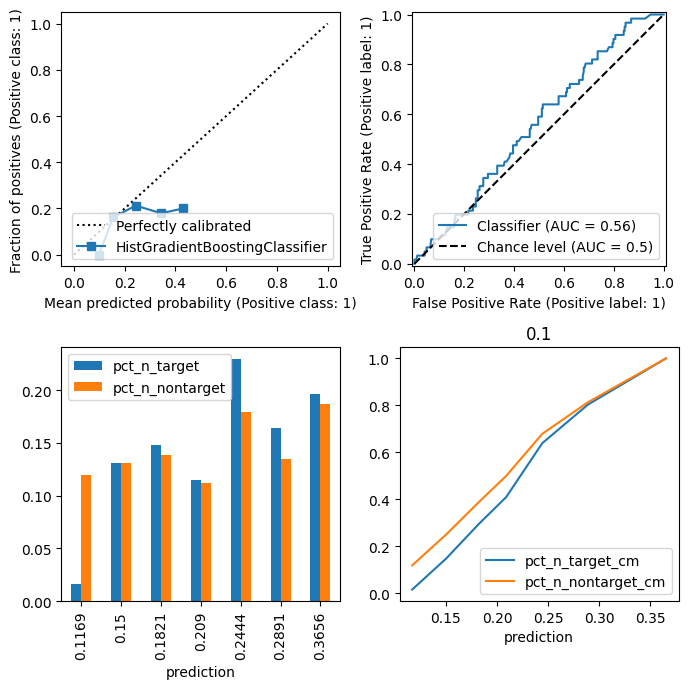

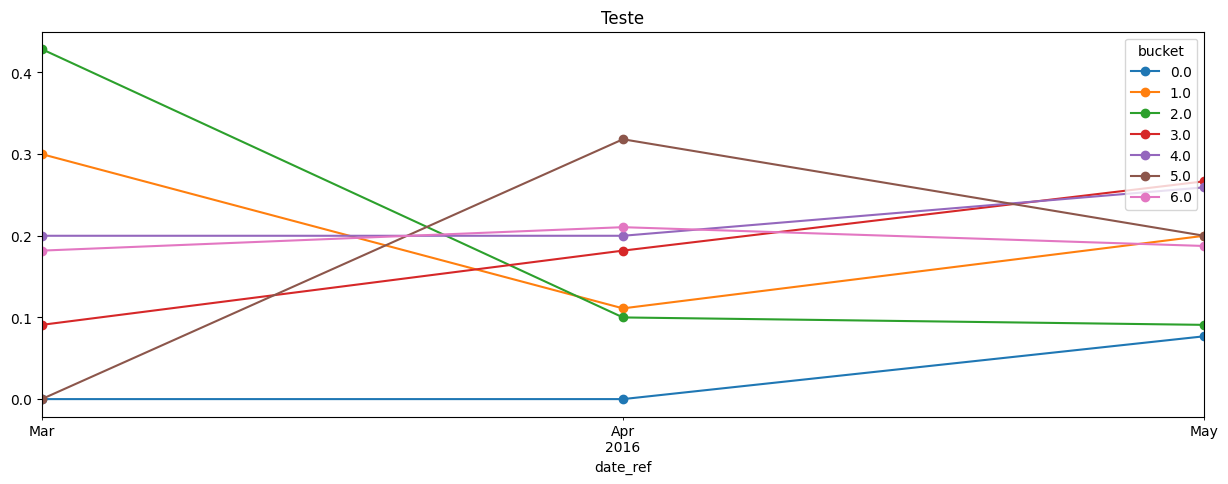

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
report = (
    df_bike_v4
    # .query('is_train == 1')
    .query('is_test == 1')
    .groupby('bucket')
    .agg(
        prediction=('prediction','mean'),
        n=('n_rents','count'),
        n_target=('target','sum'),
    )
    .eval('n_nontarget = n - n_target')
    .eval('target_rate = n_target/ n ')
    .eval('pct_n = n/n.sum()')
    .eval('pct_n_target = n_target/n_target.sum()')
    .eval('pct_n_nontarget = n_nontarget/n_nontarget.sum()')
    .eval('pct_n_target_cm = n_target.cumsum()/n_target.sum()')
    .eval('pct_n_nontarget_cm = n_nontarget.cumsum()/n_nontarget.sum()')
    .eval('ks = abs(pct_n_target_cm - pct_n_nontarget_cm)')
    .eval('error = abs(target_rate - prediction)')
    .round(4)
)
display(
    report
    .style
    .background_gradient(cmap='Reds', subset=['target_rate','prediction'])
)

display(report['error'].max())

fig, axs = plt.subplots(2,2, figsize=(7,7), tight_layout=True)
axs = axs.flatten().tolist();

CalibrationDisplay.from_predictions(
    df_bike_v4.query('is_test == 1')[y_target],
    df_bike_v4.query('is_test == 1')['prediction'],
    ax=axs[0],
    n_bins=10,
    name='HistGradientBoostingClassifier',
)
RocCurveDisplay.from_predictions(
        df_bike_v4.query('is_test == 1')[y_target],
        df_bike_v4.query('is_test == 1')['prediction'],
        ax=axs[1],
        plot_chance_level=True
)
report.plot(x='prediction', y=['pct_n_target','pct_n_nontarget'], kind='bar', ax=axs[2])
report.plot(x='prediction', y=['pct_n_target_cm','pct_n_nontarget_cm'], title=f'{report["ks"].max():0.2}', ax=axs[3])



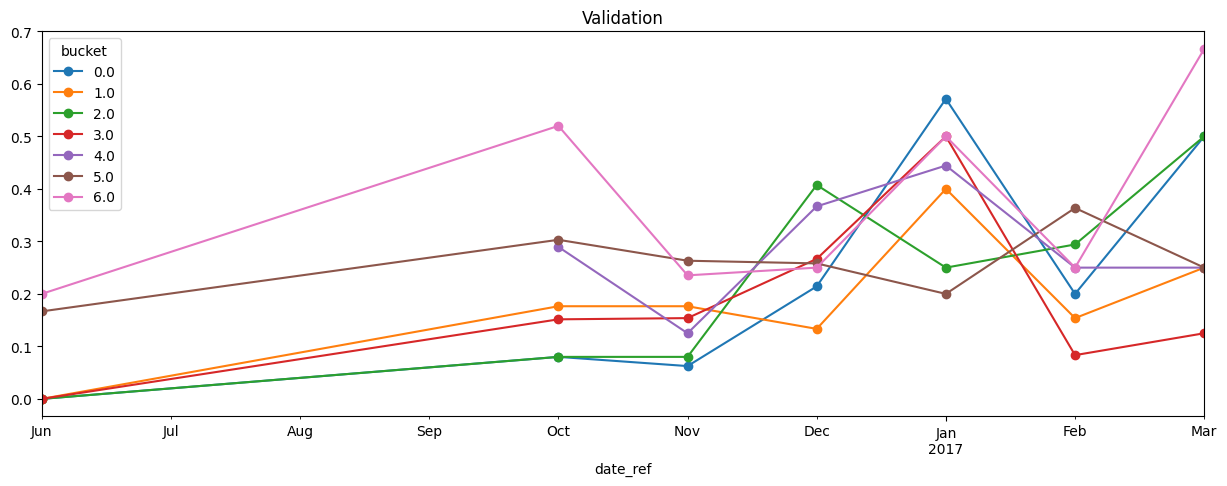

In [ ]:
plot_ts(df_bike_v4.query('is_validation == 1'), title="Validation")